# Walking in JaxSim

This notebook demonstrates how to use comodo with JaxSim simulator to control the walking motion of a humanoid robot.

Here's a list of acronyms used in the notebook:
- `lf`, `rf`: left foot, right foot
- `js`: JaxSim
- `tsid`: Task Space Inverse Dynamics
- `mpc`: Model Predictive Control
- `sfp`: Swing Foot Planner
- `mj`: Mujoco
- `s`: joint positions
- `ds`: joint velocities
- `τ`: joint torques
- `b`: base
- `com`: center of mass
- `dcom`: center of mass velocity

In [1]:
# ==== Imports ====
from __future__ import annotations
import xml.etree.ElementTree as ET
import jax.numpy as jnp
import numpy as np
import tempfile
import urllib.request
import time
import os
import matplotlib.pyplot as plt
import datetime
import pathlib
from pathlib import Path
import traceback

# Here we set some environment variables
# Flag to solve MUMPS hanging
os.environ["OMP_NUM_THREADS"] = "1"

from comodo.jaxsimSimulator import JaxsimSimulator, JaxsimContactModelEnum
from comodo.robotModel.robotModel import RobotModel
from comodo.robotModel.createUrdf import createUrdf
from comodo.centroidalMPC.centroidalMPC import CentroidalMPC
from comodo.centroidalMPC.mpcParameterTuning import MPCParameterTuning
from comodo.TSIDController.TSIDParameterTuning import TSIDParameterTuning
from comodo.TSIDController.TSIDController import TSIDController

jaxsim[237261] INFO Enabling JAX to use 64-bit precision


In [2]:
# ==== Load the stickbot model ====

# Getting stickbot urdf file and convert it to string
urdf_robot_file = tempfile.NamedTemporaryFile(mode="w+")
url = "https://raw.githubusercontent.com/icub-tech-iit/ergocub-gazebo-simulations/master/models/stickBot/model.urdf"
urllib.request.urlretrieve(url, urdf_robot_file.name)
# Load the URDF file
tree = ET.parse(urdf_robot_file.name)
root = tree.getroot()

# Convert the XML tree to a string
robot_urdf_string_original = ET.tostring(root)

create_urdf_instance = createUrdf(
    original_urdf_path=urdf_robot_file.name, save_gazebo_plugin=False
)

joint_names = [
    "r_shoulder_pitch",  # 0
    "r_shoulder_roll",  # 1
    "r_shoulder_yaw",  # 2
    "r_elbow",  # 3
    "l_shoulder_pitch",  # 4
    "l_shoulder_roll",  # 5
    "l_shoulder_yaw",  # 6
    "l_elbow",  # 7
    "r_hip_pitch",  # 8
    "r_hip_roll",  # 9
    "r_hip_yaw",  # 10
    "r_knee",  # 11
    "r_ankle_pitch",  # 12
    "r_ankle_roll",  # 13
    "l_hip_pitch",  # 14
    "l_hip_roll",  # 15
    "l_hip_yaw",  # 16
    "l_knee",  # 17
    "l_ankle_pitch",  # 18
    "l_ankle_roll",  # 19
]

urdf_robot_string = create_urdf_instance.write_urdf_to_file()
robot_model_init = RobotModel(urdf_robot_string, "stickBot", joint_names)
robot_model_init.set_foot_corner(
    np.asarray([0.1, 0.05, 0.0]),
    np.asarray([0.1, -0.05, 0.0]),
    np.asarray([-0.1, -0.05, 0.0]),
    np.asarray([-0.1, 0.05, 0.0]),
)

In [3]:
# ==== Set simulation parameters ====

T = 6.0
js_dt = 0.002

In [4]:
# ==== Compute initial configuration ====

s_0, xyz_rpy_0, H_b_0 = robot_model_init.compute_desired_position_walking()

print(
    f"Initial configuration:\nBase position: {xyz_rpy_0[:3]}\nBase orientation: {xyz_rpy_0[3:]}\nJoint positions: {s_0}"
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      124
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      142

Total number of variables............................:       27
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality c

In [5]:
# ==== Define JaxSim simulator and set initial position ====

js = JaxsimSimulator(dt=js_dt, contact_model_type=JaxsimContactModelEnum.RELAXED_RIGID)
js.load_model(
    robot_model=robot_model_init,
    s=s_0,
    xyz_rpy=xyz_rpy_0,
    # Possible choices are "record", "interactive" or None (no visualization)
    visualization_mode="record",
)

s_js, ds_js, tau_js = js.get_state()
t = 0.0
H_b = js.base_transform
w_b = js.base_velocity

print(f"Contact model in use: {js._model.contact_model}")
print(f"Link names:\n{js.link_names}")
print(f"Frame names:\n{js.frame_names}")

jaxsim[237261] DEBUG Found model 'stickBot' in SDF resource
/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/rod/sdf/model.py:166: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  switch_frame_convention(
jaxsim[237261] DEBUG Model 'stickBot' is floating-base
jaxsim[237261] DEBUG Considering 'root_link' as base link
jaxsim[237261] INFO Lumping chain: r_foot_rear->(r_foot_rear_ft_sensor)->r_ankle_2
jaxsim[237261] INFO Lumping chain: r_foot_front->(r_foot_front_ft_sensor)->r_ankle_2
jaxsim[237261] INFO Lumping chain: l_foot_rear->(l_foot_rear_ft_sensor)->l_ankle_2
jaxsim[237261] INFO Lumping chain: l_foot_front->(l_foot_front_ft_sensor)->l_ankle_2
jaxsim[237261] INFO Lumping chain: r_shoulder_3->(r_arm_ft_sensor)->r_shoulder_2
jaxsim[237261] INFO Lumping chain: l_shoulder_3->(l_arm_ft_sensor)->l_shoulder_2
jaxsim[237261] INFO Lumping chain: r_hip_3->(r_leg_ft_sensor)->r_hip_2
jaxsim

Contact model in use: RelaxedRigidContacts(_solver_options_keys=('tol', 'maxiter', 'memory_size'), _solver_options_values=(1e-06, 50, 10))
Link names:
['root_link', 'l_hip_1', 'l_shoulder_1', 'r_hip_1', 'r_shoulder_1', 'l_hip_2', 'l_shoulder_2', 'r_hip_2', 'r_shoulder_2', 'l_upper_leg', 'l_upper_arm', 'r_upper_leg', 'r_upper_arm', 'l_lower_leg', 'l_elbow_1', 'r_lower_leg', 'r_elbow_1', 'l_ankle_1', 'r_ankle_1', 'l_ankle_2', 'r_ankle_2']
Frame names:
['base_link', 'base_link_fixed_joint', 'camera_tilt', 'chest', 'head', 'imu_frame', 'imu_frame_fixed_joint', 'l_foot_front', 'l_foot_rear', 'l_forearm', 'l_hand', 'l_hip_3', 'l_shoulder_3', 'l_sole', 'l_sole_fixed_joint', 'l_wrist_1', 'lidar', 'neck_1', 'neck_2', 'neck_3', 'neck_fixed_joint', 'r_foot_front', 'r_foot_rear', 'r_forearm', 'r_hand', 'r_hip_3', 'r_shoulder_3', 'r_sole', 'r_sole_fixed_joint', 'r_wrist_1', 'torso_1', 'torso_2']


In [6]:
# ==== Define the controller parameters  and instantiate the controller ====

# Controller Parameters
tsid_parameter = TSIDParameterTuning()
tsid_parameter.foot_tracking_task_kp_lin = 150.0
tsid_parameter.foot_tracking_task_kd_lin = 40.0
tsid_parameter.root_tracking_task_weight = np.ones(3) * 50.0

mpc_parameters = MPCParameterTuning()

# TSID Instance
tsid = TSIDController(frequency=0.01, robot_model=robot_model_init)
tsid.define_tasks(tsid_parameter)
tsid.set_state_with_base(s_js, ds_js, H_b, w_b, t)

# MPC Instance
step_length = 0.1
mpc = CentroidalMPC(robot_model=robot_model_init, step_length=step_length)
mpc.intialize_mpc(mpc_parameters=mpc_parameters, scale=0.5)

# Set desired quantities
mpc.configure(s_init=s_0, H_b_init=H_b_0)
tsid.compute_com_position()
mpc.define_test_com_traj(tsid.COM.toNumPy())

MPC Initialized


In [7]:
# Set initial robot state  and plan trajectories

tic = time.perf_counter()

js.step(dry_run=True)

step_compilation_time_s = time.perf_counter() - tic

In [8]:
# Reading the state
s_js, ds_js, tau_js = js.get_state()
H_b = js.base_transform
w_b = js.base_velocity

# MPC
mpc.set_state_with_base(s=s_js, s_dot=ds_js, H_b=H_b, w_b=w_b, t=t)
mpc.initialize_centroidal_integrator(s=s_js, s_dot=ds_js, H_b=H_b, w_b=w_b, t=t)
mpc_output = mpc.plan_trajectory()

In [9]:
# ==== Define the simulation loop ====


def simulate(
    T: float,
    js: JaxsimSimulator,
    tsid: TSIDController,
    mpc: CentroidalMPC,
    s_ref: list[float],
) -> dict[str, np.array]:
    # Logging
    s_js_log = []
    ds_js_log = []
    W_p_CoM_js_log = []
    W_p_lf_js_log = []
    W_p_rf_js_log = []
    W_p_CoM_mpc_log = []
    W_p_lf_sfp_log = []
    W_p_rf_sfp_log = []
    f_lf_mpc_log = []
    f_rf_mpc_log = []
    f_lf_js_log = []
    f_rf_js_log = []
    tau_tsid_log = []
    W_p_CoM_tsid_log = []
    t_log = []
    wall_time_step_log = []

    # Define number of steps
    n_step_tsid_js = int(tsid.frequency / js_dt)
    n_step_mpc_tsid = int(mpc.get_frequency_seconds() / tsid.frequency)
    print(f"{n_step_mpc_tsid=}, {n_step_tsid_js=}")
    counter = 0
    mpc_success = True
    succeded_controller = True
    contact_model_type = js.contact_model_type

    t = 0.0

    while t < T:
        try:
            print(f"==== Time: {t:.4f}s ====", flush=True, end="\r")

            # Reading robot state from simulator
            s_js, ds_js, tau_js = js.get_state()
            H_b = js.base_transform
            w_b = js.base_velocity
            t = js.simulation_time

            # Update TSID
            tsid.set_state_with_base(s=s_js, s_dot=ds_js, H_b=H_b, w_b=w_b, t=t)

            # MPC plan
            if counter == 0:
                mpc.set_state_with_base(s=s_js, s_dot=ds_js, H_b=H_b, w_b=w_b, t=t)
                mpc.update_references()
                mpc_success = mpc.plan_trajectory()
                mpc.contact_planner.advance_swing_foot_planner()
                if not (mpc_success):
                    print("MPC failed")
                    break

            # Reading new references
            com_mpc, dcom_mpc, f_lf_mpc, f_rf_mpc, ang_mom_mpc = mpc.get_references()
            lf_sfp, rf_sfp = mpc.contact_planner.get_references_swing_foot_planner()

            tsid.compute_com_position()

            # Update references TSID
            tsid.update_task_references_mpc(
                com=com_mpc,
                dcom=dcom_mpc,
                ddcom=np.zeros(3),
                left_foot_desired=lf_sfp,
                right_foot_desired=rf_sfp,
                s_desired=np.array(s_ref),
                wrenches_left=np.hstack([f_lf_mpc, np.zeros(3)]),
                wrenches_right=np.hstack([f_rf_mpc, np.zeros(3)]),
            )

            # Run control
            succeded_controller = tsid.run()

            if not (succeded_controller):
                print("Controller failed")
                break

            tau_tsid = tsid.get_torque()

            # Step the simulator
            js.set_input(tau_tsid)

            tic = time.perf_counter()
            js.step(n_step=n_step_tsid_js)
            toc = time.perf_counter() - tic

            counter = counter + 1

            if counter == n_step_mpc_tsid:
                counter = 0

            # Stop the simulation if the robot fell down
            # if js._data.base_position()[2] < 0.5:
            #     print(f"Robot fell down at t={t:.4f}s.")
            #     break

            # Log data
            # TODO transform mpc contact forces to wrenches to be compared with jaxsim ones
            t_log.append(t)
            tau_tsid_log.append(tau_tsid)
            s_js_log.append(s_js)
            ds_js_log.append(ds_js)
            W_p_CoM_js_log.append(js.com_position)
            W_p_lf_js, W_p_rf_js = js.feet_positions
            W_p_lf_js_log.append(W_p_lf_js)
            W_p_rf_js_log.append(W_p_rf_js)
            W_p_CoM_mpc_log.append(com_mpc)
            f_lf_mpc_log.append(f_lf_mpc)
            f_rf_mpc_log.append(f_rf_mpc)
            W_p_lf_sfp_log.append(lf_sfp.transform.translation())
            W_p_rf_sfp_log.append(rf_sfp.transform.translation())
            W_p_CoM_tsid_log.append(tsid.COM.toNumPy())
            wall_time_step_log.append(toc * 1e3)
            if contact_model_type != JaxsimContactModelEnum.VISCO_ELASTIC:
                f_lf_js, f_rf_js = js.feet_wrench
                f_lf_js_log.append(f_lf_js)
                f_rf_js_log.append(f_rf_js)

        except Exception as e:
            print(f"Exception during simulation at time{t}: {e}")
            traceback.print_exc()
            break

    logs = {
        "t": np.array(t_log),
        "s_js": np.array(s_js_log),
        "ds_js": np.array(ds_js_log),
        "tau_tsid": np.array(tau_tsid_log),
        "W_p_CoM_js": np.array(W_p_CoM_js_log),
        "W_p_lf_js": np.array(W_p_lf_js_log),
        "W_p_rf_js": np.array(W_p_rf_js_log),
        "W_p_CoM_mpc": np.array(W_p_CoM_mpc_log),
        "f_lf_mpc": np.array(f_lf_mpc_log),
        "f_rf_mpc": np.array(f_rf_mpc_log),
        "W_p_lf_sfp": np.array(W_p_lf_sfp_log),
        "W_p_rf_sfp": np.array(W_p_rf_sfp_log),
        "W_p_CoM_tsid": np.array(W_p_CoM_tsid_log),
        "wall_time_step": np.array(wall_time_step_log),
    }
    if contact_model_type != JaxsimContactModelEnum.VISCO_ELASTIC:
        logs["f_lf_js"] = np.array(f_lf_js_log)
        logs["f_rf_js"] = np.array(f_rf_js_log)

    return logs

In [10]:
# ==== Run the simulation ====


now = time.perf_counter()

logs = simulate(T=T, js=js, tsid=tsid, mpc=mpc, s_ref=s_0)

wall_time = time.perf_counter() - now
avg_iter_time_ms = (wall_time / (T / js_dt)) * 1000

print(
    f"\nSimulation done.\nRunning simulation took {wall_time:.2f}s for {T:.3f}s simulated time."
)

n_step_mpc_tsid=10, n_step_tsid_js=5
==== Time: 6.0000s ====
Simulation done.
Running simulation took 147.75s for 6.000s simulated time.


In [11]:
# Extract logged variables
t = logs["t"]
s_js = logs["s_js"]
ds_js = logs["ds_js"]
tau_tsid = logs["tau_tsid"]
W_p_CoM_js = logs["W_p_CoM_js"]
W_p_lf_js = logs["W_p_lf_js"]
W_p_rf_js = logs["W_p_rf_js"]
W_p_CoM_mpc = logs["W_p_CoM_mpc"]
f_lf_mpc = logs["f_lf_mpc"]
f_rf_mpc = logs["f_rf_mpc"]
W_p_lf_sfp = logs["W_p_lf_sfp"]
W_p_rf_sfp = logs["W_p_rf_sfp"]
W_p_CoM_tsid = logs["W_p_CoM_tsid"]
wall_time_step = logs["wall_time_step"]
if js.contact_model_type != JaxsimContactModelEnum.VISCO_ELASTIC:
    f_lf_js = logs["f_lf_js"]
    f_rf_js = logs["f_rf_js"]

In [12]:
# Compute simulator step runtime statistics and RTF

min_step_time = np.min(wall_time_step)
max_step_time = np.max(wall_time_step)
avg_step_time = np.mean(wall_time_step)
std_step_time = np.std(wall_time_step)
total_step_time = np.sum(wall_time_step)
rtf = (T * 1e3) / total_step_time * 100

print("===========================================")
print(f"Step compilation time: {step_compilation_time_s:.2f} s")
print(f"Min step time: {min_step_time:.2f} ms")
print(f"Max step time: {max_step_time:.2f} ms")
print(f"Average step time: {avg_step_time:.2f} ms")
print(f"Std deviation step time: {std_step_time:.2f} ms")
print(f"RTF: {rtf:.1f}%")
print("===========================================")

Step compilation time: 9.13 s
Min step time: 156.74 ms
Max step time: 8663.94 ms
Average step time: 219.07 ms
Std deviation step time: 344.72 ms
RTF: 4.5%


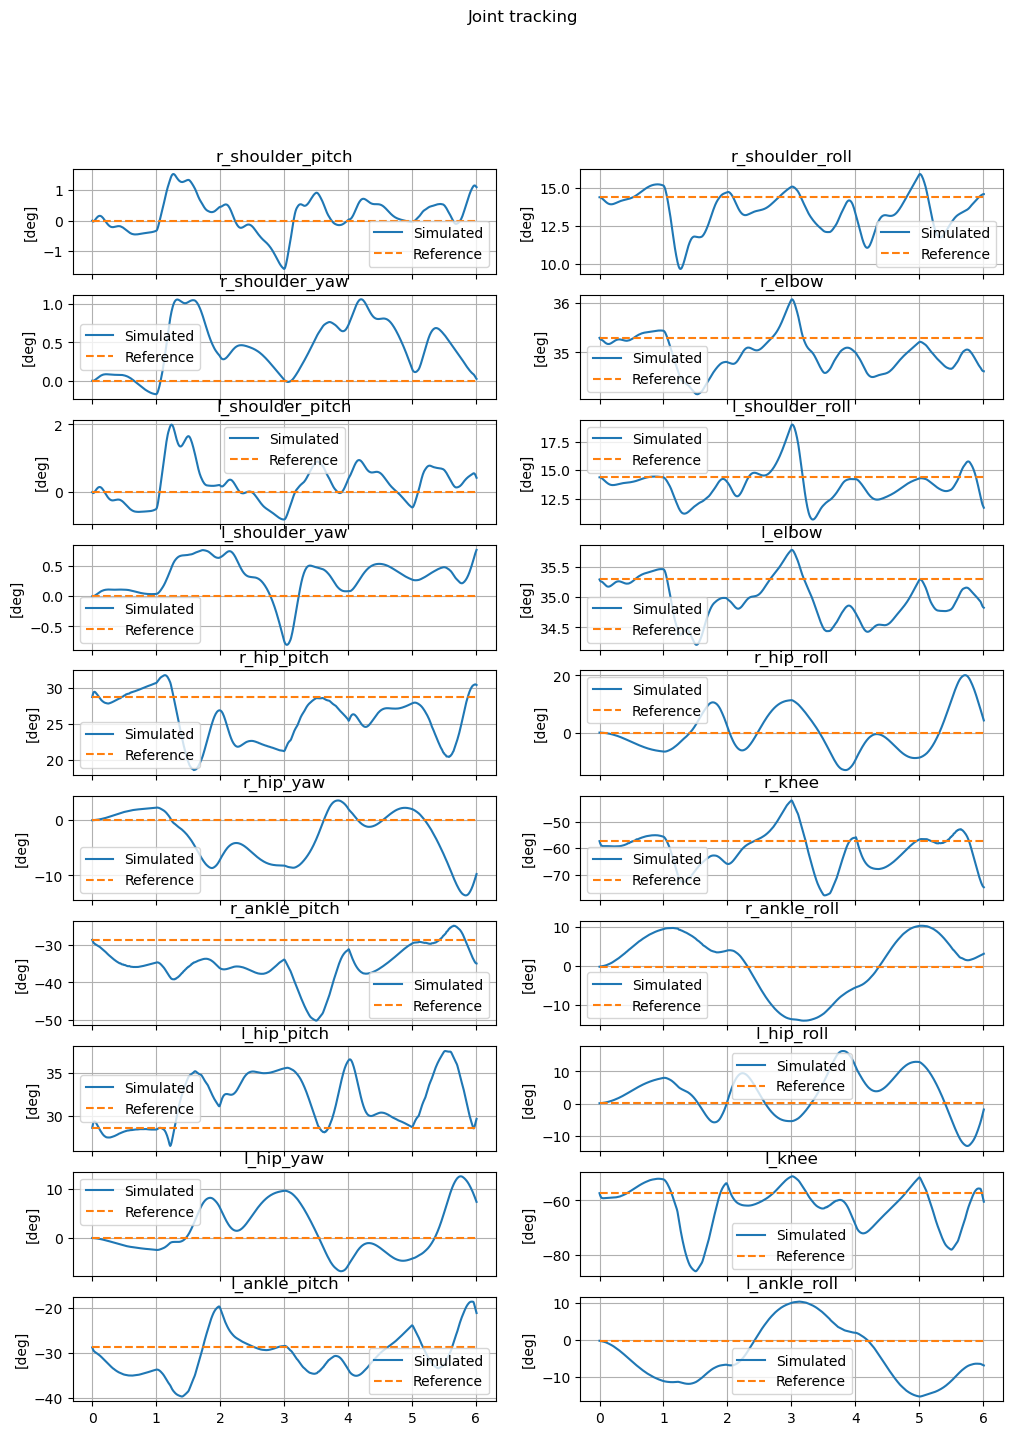

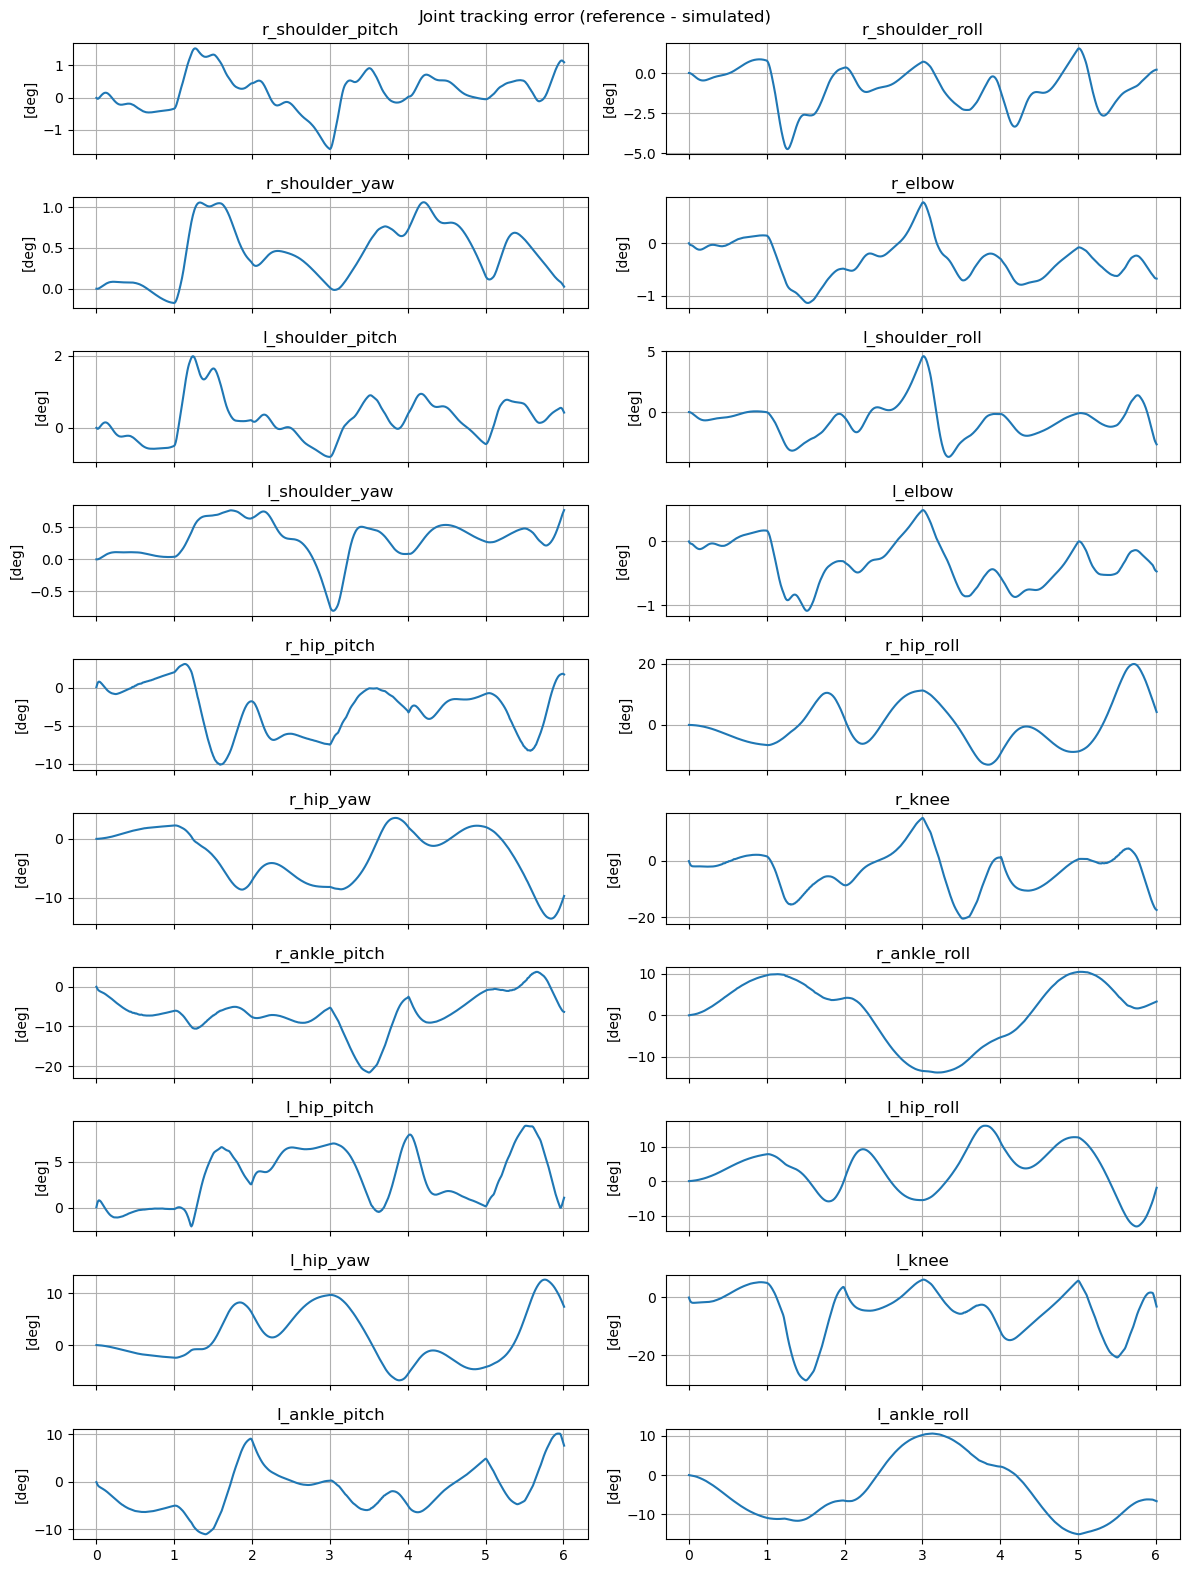

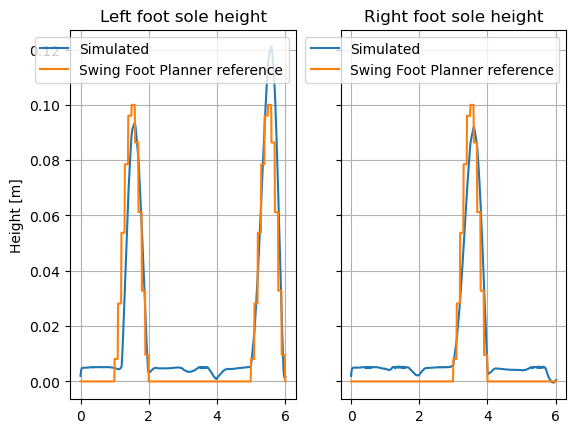

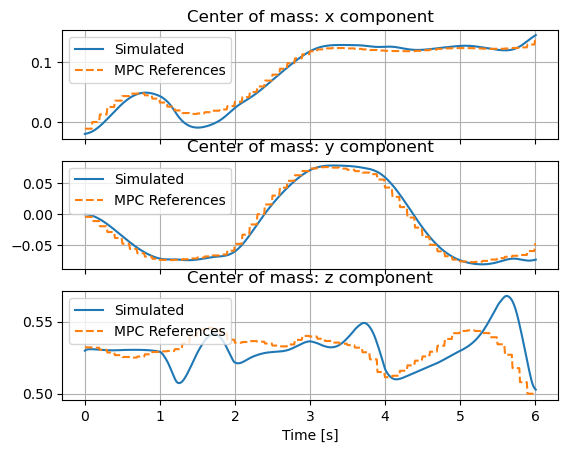

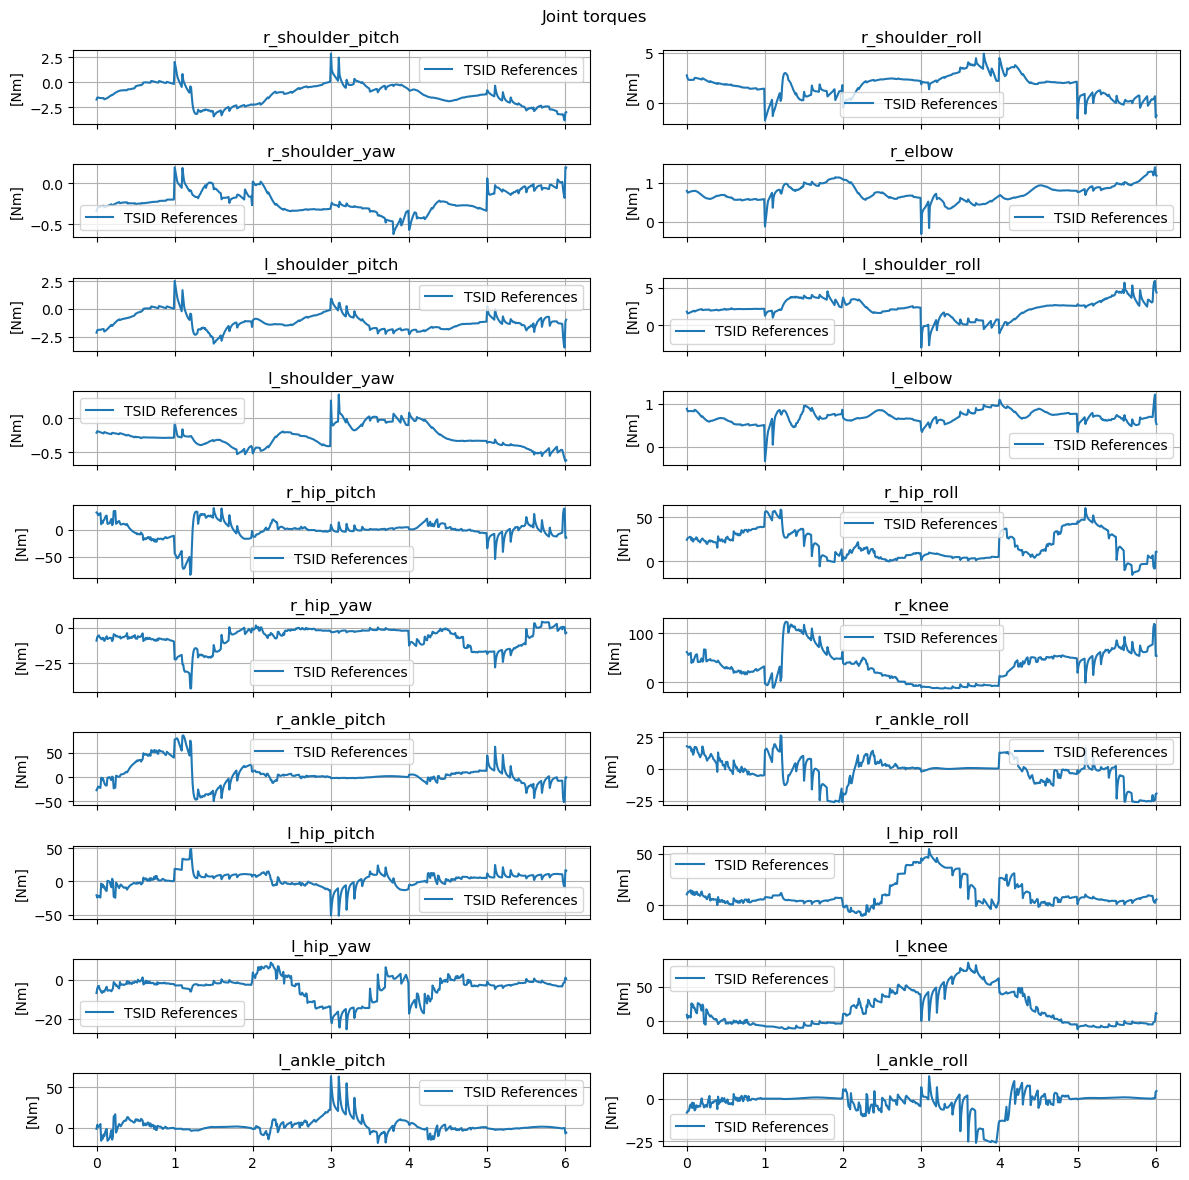

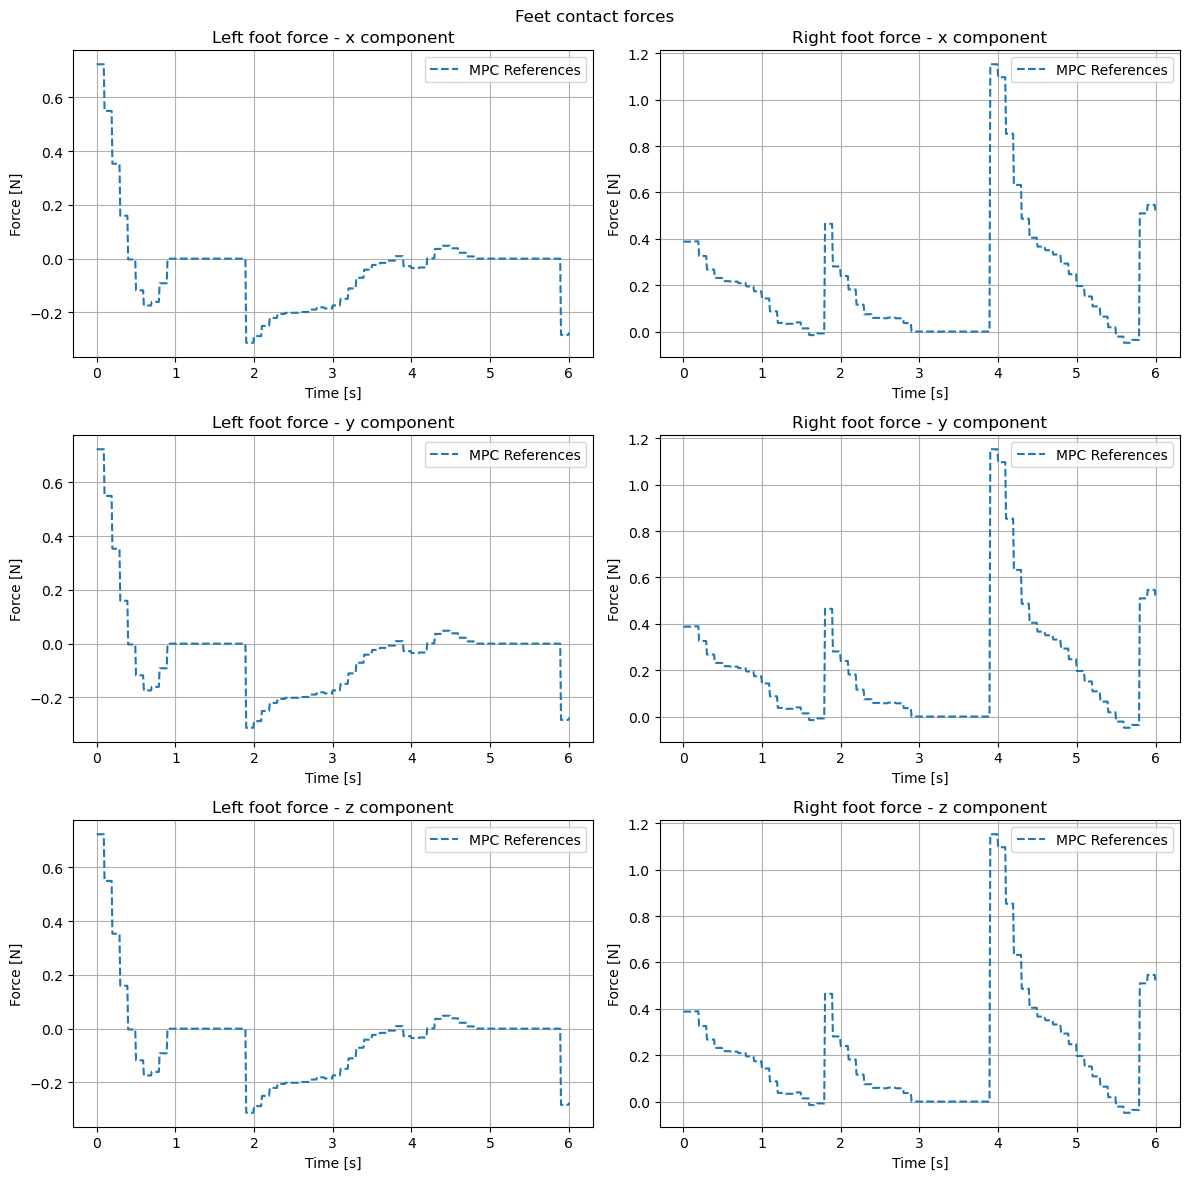

In [13]:
# ==== Plot the results ====


n_sim_steps = s_js.shape[0]
s_0 = np.full_like(a=s_js, fill_value=s_0)

# Joint tracking
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(joint_names) / 2)), ncols=2, sharex=True, figsize=(12, 16)
)
for idx, name in enumerate(joint_names):
    ax = axs[idx // 2, idx % 2]
    ax.title.set_text(name)
    ax.plot(t, s_js[:, idx] * 180 / np.pi, label="Simulated")
    ax.plot(
        t,
        s_0[:, idx] * 180 / np.pi,
        linestyle="--",
        label="Reference",
    )
    ax.grid()
    ax.set_ylabel("[deg]")
    ax.legend()
plt.suptitle("Joint tracking")
plt.show()

# Joint tracking error
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(joint_names) / 2)), ncols=2, sharex=True, figsize=(12, 16)
)
for idx, name in enumerate(joint_names):
    ax = axs[idx // 2, idx % 2]
    ax.title.set_text(name)
    ax.plot(t, (s_js[:, idx] - s_0[:, idx]) * 180 / np.pi)
    ax.grid()
    ax.set_ylabel("[deg]")
plt.suptitle("Joint tracking error (reference - simulated)")
plt.tight_layout()
plt.show()

# Feet height
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
ax = axs[0]
ax.title.set_text("Left foot sole height")
ax.plot(t, W_p_lf_js[:, 2], label="Simulated")
ax.plot(t, W_p_lf_sfp[:, 2], label="Swing Foot Planner reference")
ax.legend()
ax.grid()
ax.set_ylabel("Height [m]")
ax = axs[1]
ax.title.set_text("Right foot sole height")
ax.plot(t, W_p_rf_js[:, 2], label="Simulated")
ax.plot(t, W_p_rf_sfp[:, 2], label="Swing Foot Planner reference")
ax.legend()
ax.grid()
plt.show()

# COM tracking
fig = plt.figure()
ax1, ax2, ax3 = fig.subplots(nrows=3, ncols=1, sharex=True)
ax1.title.set_text("Center of mass: x component")
ax1.plot(t, W_p_CoM_js[:, 0], label="Simulated")
ax1.plot(t, W_p_CoM_mpc[:, 0], linestyle="--", label="MPC References")
ax2.title.set_text("Center of mass: y component")
ax2.plot(t, W_p_CoM_js[:, 1], label="Simulated")
ax2.plot(t, W_p_CoM_mpc[:, 1], linestyle="--", label="MPC References")
ax3.title.set_text("Center of mass: z component")
ax3.plot(t, W_p_CoM_js[:, 2], label="Simulated")
ax3.plot(t, W_p_CoM_mpc[:, 2], linestyle="--", label="MPC References")
ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid()
ax2.grid()
ax3.grid()
plt.xlabel("Time [s]")
plt.show(block=False)

# Torques
fig, axs = plt.subplots(
    nrows=int(np.ceil(len(joint_names) / 2)), ncols=2, sharex=True, figsize=(12, 12)
)
for idx, name in enumerate(joint_names):
    ax = axs[idx // 2, idx % 2]
    ax.title.set_text(name)
    ax.plot(t, tau_tsid[:, idx], label="TSID References")
    ax.legend()
    ax.grid()
    ax.set_ylabel("[Nm]")
plt.suptitle("Joint torques")
plt.tight_layout()
plt.show()

# Contact forces
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
titles = [
    "Left foot force - x component",
    "Right foot force - x component",
    "Left foot force - y component",
    "Right foot force - y component",
    "Left foot force - z component",
    "Right foot force - z component",
]
for row in range(3):
    for col in range(2):
        idx = row * 2 + col
        # force_js = f_lf_js[:, col] if col == 0 else f_rf_js[:, col]
        force_mpc = f_lf_mpc[:, col] if col == 0 else f_rf_mpc[:, col]
        # axs[row, col].plot(t, force_js, label="Simulated")
        axs[row, col].plot(t, force_mpc, linestyle="--", label="MPC References")
        axs[row, col].set_title(titles[idx])
        axs[row, col].set_ylabel("Force [N]")
        axs[row, col].set_xlabel("Time [s]")
        axs[row, col].grid()
        axs[row, col].legend()

plt.suptitle("Feet contact forces")
plt.tight_layout()
plt.show()

In [14]:
# ==== Generate video ====
# Create results folder if not existing
def get_repo_root(
    current_path: Path = Path(os.path.abspath("jaxsim_walking.ipynb")).parent,
) -> Path:
    current_path = current_path.resolve()

    for parent in current_path.parents:
        if (parent / ".git").exists():
            return parent

    raise RuntimeError("No .git directory found, not a Git repository.")


def create_output_dir(directory: Path):
    # Create the directory if it doesn't exist
    directory.mkdir(parents=True, exist_ok=True)


# Usage
repo_root = get_repo_root()

# Define the results directory
results_dir = repo_root / "examples" / "results"

# Create the results directory if it doesn't exist
create_output_dir(results_dir)
now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
filepath = results_dir / pathlib.Path(current_time + "simulation_comodo.mp4")
js._save_video(filepath)
print(f"Video saved at: {filepath}")

Video saved at: /home/fferretti-iit.local/git/comodo/examples/results/2025-01-23_17-10-47simulation_comodo.mp4


In [15]:
torques = jnp.array(logs["tau_tsid"])
batched_torques = jnp.repeat(torques[None, ...], 512, axis=0)

import jax

print(f"Running on {jax.devices()}")

Running on [CudaDevice(id=0)]


In [16]:
batched_torques.shape

(512, 602, 20)

In [17]:
s_0, xyz_rpy_0, H_b_0 = robot_model_init.compute_desired_position_walking()

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      124
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      142

Total number of variables............................:       27
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2479115e-03 1.00e+00 1.95e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [18]:
import jaxsim.api as js

model = js.model.JaxSimModel.build_from_model_description(
    model_description=robot_model_init.urdf_string,
    time_step=js_dt,
    considered_joints=joint_names,
)

get_joint_map = lambda from_, to: np.array(list(map(from_.index, to)))
_to_js = get_joint_map(from_=joint_names, to=model.joint_names())
_to_user = get_joint_map(from_=model.joint_names(), to=joint_names)

data = js.data.JaxSimModelData.build(
    model=model, base_position=xyz_rpy_0[:3], joint_positions=s_0[_to_js]
)

batched_data = jax.vmap(
    lambda xyz, s: js.data.JaxSimModelData.build(
        model=model, base_position=xyz, joint_positions=s
    ),
    in_axes=(0, 0),
)(
    jnp.repeat(xyz_rpy_0[0:3], 512).reshape(512, -1),
    jnp.repeat(s_0[_to_js], 512).reshape(512, -1),
)

jit_step = jax.jit(jax.vmap(js.model.step, in_axes=(None,)))

jaxsim[237261] DEBUG Found model 'stickBot' in SDF resource
/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/rod/sdf/model.py:166: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  switch_frame_convention(
jaxsim[237261] DEBUG Model 'stickBot' is floating-base
jaxsim[237261] DEBUG Considering 'root_link' as base link
jaxsim[237261] INFO Lumping chain: r_foot_rear->(r_foot_rear_ft_sensor)->r_ankle_2
jaxsim[237261] INFO Lumping chain: r_foot_front->(r_foot_front_ft_sensor)->r_ankle_2
jaxsim[237261] INFO Lumping chain: l_foot_rear->(l_foot_rear_ft_sensor)->l_ankle_2
jaxsim[237261] INFO Lumping chain: l_foot_front->(l_foot_front_ft_sensor)->l_ankle_2
jaxsim[237261] INFO Lumping chain: r_shoulder_3->(r_arm_ft_sensor)->r_shoulder_2
jaxsim[237261] INFO Lumping chain: l_shoulder_3->(l_arm_ft_sensor)->l_shoulder_2
jaxsim[237261] INFO Lumping chain: r_hip_3->(r_leg_ft_sensor)->r_hip_2
jaxsim

jaxsim[237261] WARNING This method is deprecated. Use 'ModelToMjcf.convert' instead.
/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/rod/sdf/model.py:166: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  switch_frame_convention(


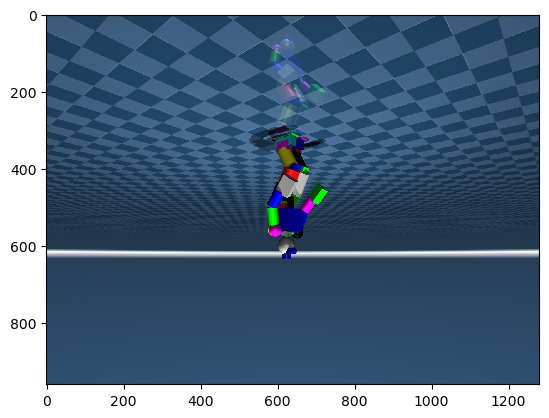

In [21]:
from jaxsim.mujoco import MujocoVideoRecorder, UrdfToMjcf, MujocoModelHelper
%matplotlib inline
from matplotlib import pyplot as plt

mjcf_string, assets = UrdfToMjcf.convert(
    urdf=model.built_from,
)

_mj_model_helper = MujocoModelHelper.build_from_xml(
    mjcf_description=mjcf_string, assets=assets
)

_recorder = MujocoVideoRecorder(
    model=_mj_model_helper.model,
    data=_mj_model_helper.data,
    fps=30,
    width=320 * 4,
    height=240 * 4,
)


_mj_model_helper.set_base_position(
    position=np.array(data.base_position),
)
_mj_model_helper.set_base_orientation(
    orientation=np.array(data.base_orientation()),
)
_mj_model_helper.set_joint_positions(
    positions=np.array(data.joint_positions),
    joint_names=model.joint_names(),
)

plt.imshow(_recorder.render_frame(), interpolation='nearest')
plt.show()

In [19]:
import time

batched_torques = batched_torques.reshape(-1, 512, 20)

now = time.perf_counter()
for batched_torque in batched_torques:
    batched_data = jit_step(
        model, data=batched_data, joint_force_references=batched_torque[:, _to_js]
    )

wall_time = time.perf_counter() - now

jax.debug.callback failed
Traceback (most recent call last):
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/debugging.py", line 93, in debug_callback_impl
    callback(*args)
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/debugging.py", line 278, in _flat_callback
    callback(*args, **kwargs)
  File "/home/fferretti-iit.local/git/jaxsim/src/jaxsim/exceptions.py", line 42, in _raise_exception
    raise exception(msg.format(*args, **kwargs))
ValueError: A RBDA received a quaternion that is not normalized.
E0123 17:11:18.811910  237261 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel_lau

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/asyncio/base_events.py", line 640, in run_forever
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/asyncio/base_events.py", line 1992, in _run_once
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_237261/1027331872.py", line 7, in <module>
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/pjit.py", line 338, in cache_miss
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/pjit.py", line 188, in _python_pjit_helper
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/core.py", line 2803, in bind
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/core.py", line 442, in bind_with_trace
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/core.py", line 955, in process_primitive
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/pjit.py", line 1738, in _pjit_call_impl
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/pjit.py", line 1714, in call_impl_cache_miss
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/pjit.py", line 1668, in _pjit_call_impl_python
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/profiler.py", line 333, in wrapper
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1278, in __call__
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py", line 2768, in _wrapped_callback
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/debugging.py", line 160, in _callback
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/debugging.py", line 96, in debug_callback_impl
  File "/home/fferretti-iit.local/miniforge3/envs/comodoGPU/lib/python3.12/site-packages/jax/_src/debugging.py", line 278, in _flat_callback
  File "/home/fferretti-iit.local/git/jaxsim/src/jaxsim/exceptions.py", line 42, in _raise_exception
ValueError: A RBDA received a quaternion that is not normalized.

In [ ]:
rtf = T / wall_time * 512